In [ ]:
DATASET_DIRECTORY = '/content/drive/MyDrive/PhD research/Stress Detection/Stress Detection/electrocardiogram-skin-conductance-and-respiration-from-spider-fearful-individuals-watching-spider-video-clips-1.0.0'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

from sklearn.metrics import accuracy_score

In [ ]:
filepath = DATASET_DIRECTORY + '/VP02/BitalinoECG.txt'
df = pd.read_csv(filepath, sep="\t", header = None)
df.head()

,0,1,2
0,-0.055664,112755.578,Raw
1,-0.014648,112755.594,Raw
2,0.005859,112755.599,Raw
3,0.023438,112755.605,Raw
4,0.035156,112755.624,Raw


In [ ]:
print(len(df))

224574


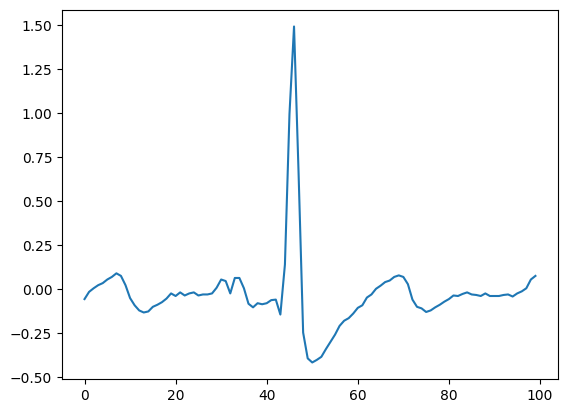

In [ ]:
plt.plot(np.array(df[:100][0]))

In [ ]:
filepath = DATASET_DIRECTORY + '/VP02/Triggers.txt'
dfTrigger = pd.read_csv(filepath, sep="\t", header = None)
dfTrigger['clip_duration'] = (dfTrigger[2] - dfTrigger[1])/100
dfTrigger

,0,1,2,clip_duration
0,CLIP-DEMO,113153,113303,1.50
1,CLIP-4,113336,113437,1.01
2,CLIP-1,113453,113553,1.00
3,CLIP-3,113616,113716,1.00
4,CLIP-2,113731,113832,1.01
5,CLIP-7,113923,114023,1.00
6,CLIP-8,114038,114139,1.01
7,CLIP-5,114158,114258,1.00
8,CLIP-6,114314,114415,1.01
9,CLIP-12,114606,114707,1.01


# Signal Resample

(224574,) (1572018,)


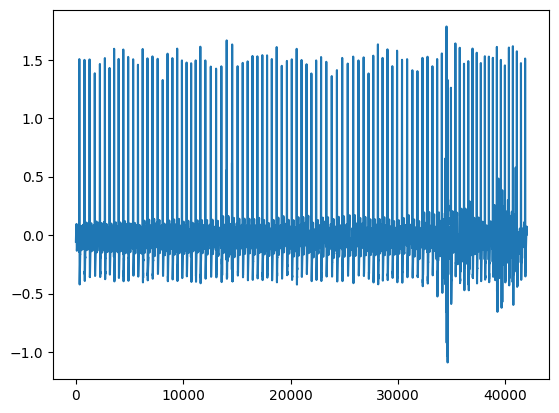

In [ ]:
ECG_raw = np.array(df[:][0])
ECGResamp = signal.resample(ECG_raw, len(ECG_raw)*7)
print(ECG_raw.shape, ECGResamp.shape)

ECGWind = ECGResamp[:60*700]
plt.plot(ECGWind)

# Label

In [ ]:
trigIndex = 0 # Trigger index tracker: ranges from 0-16
# non-stress=0; stress=1

df['label'] = [1]*len(df)
stressEcg = []
stressLabel = []
ecgOneInst = []
nonStressEcg = []

for index in range(len(df)): # iterate through df all rows

  if int(df[1][index])<dfTrigger[1][trigIndex]: # before any clip starts
    df.loc[index,'label'] = 0

  elif dfTrigger[1][trigIndex]<=int(df[1][index])<=dfTrigger[2][trigIndex]: # within the range
    df.loc[index,'label'] = 1
    ecgOneInst.append(df[0][index])


  elif int(df[1][index])>dfTrigger[2][trigIndex]:
    trigIndex +=1

    stressEcg.append(ecgOneInst[:60*100])
    stressLabel.append(1)
    ecgOneInst = []

  if trigIndex>16:
    nonStressEcg.append(np.array(df[1][index:]))
    break

In [ ]:
df.head()

,0,1,2,label
0,-0.055664,112755.578,Raw,0
1,-0.014648,112755.594,Raw,0
2,0.005859,112755.599,Raw,0
3,0.023438,112755.605,Raw,0
4,0.035156,112755.624,Raw,0


In [ ]:
df['label'].value_counts()

1    152754
0     71820
Name: label, dtype: int64

<Axes: >

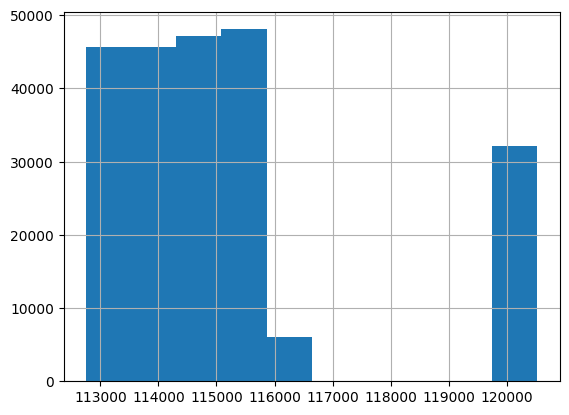

In [ ]:
df[:][1].hist()

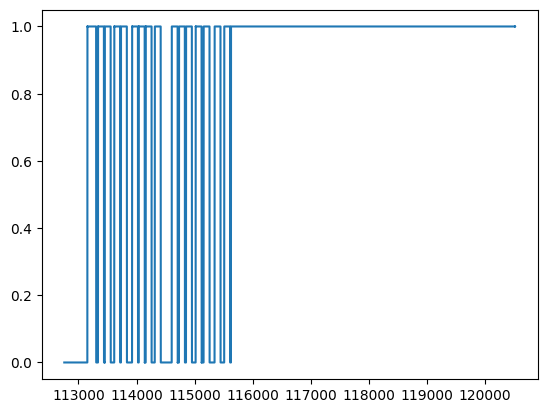

In [ ]:
plt.plot(df[1], df['label'])

In [ ]:
for i,ecg in enumerate(stressEcg):
  ecg = np.array(ecg)

  if len(ecg)<60*100:
    newEcg = np.zeros((60*100, ))
    newEcg[0:len(ecg)] = ecg
    newEcg[len(ecg):] = ecg[:(60*100 - len(ecg))] # I concat the first value to last to balance
    ecg = newEcg

  stressEcg[i] = newEcg

In [ ]:
stressEcg = np.array(stressEcg)
stressLabel = np.array(stressLabel)
print(stressEcg.shape, stressLabel.shape) # clip duration should be 60*100 = 6,000 - here 65505
print(stressLabel)

(17, 6000) (17,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Resample it 700*60

In [ ]:
resampledEcg = []
for i in range(len(stressEcg)):
  resampledEcg.append(signal.resample(ECG_raw, 60*700))
resampledEcg = np.array(resampledEcg)
resampledEcg = np.reshape(resampledEcg, (17, 60*700, 1))
print(resampledEcg.shape)
resampledEcg = torch.tensor(resampledEcg).type(torch.FloatTensor)

(17, 42000, 1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_features = 700*60
n_classes = 2

class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, 64, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(64,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,n_classes),
            nn.Softmax())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

model = ConvNet1D()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loadFileName = '/content/drive/MyDrive/PhD research/Stress Detection/WESAD training/5_6_7 on top of 2_3_4 conv1d/5_6_7_2_3_4_139_feb_88.pth'
model.load_state_dict(torch.load(loadFileName))

<All keys matched successfully>

In [ ]:
stressPred = model(resampledEcg)
stressPred = torch.argmax(stressPred, axis = 1).detach().numpy()
stressPred

print(accuracy_score(stressLabel, stressPred))

1.0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


# NonStress Pred

In [ ]:
nonStressEcgNumpy = np.array(nonStressEcg[0])
print(nonStressEcgNumpy.shape)
windowNonStress = []
nonStressLabel = []

index = 0
while(index<len(nonStressEcgNumpy)):
  windowNonStress.append(np.expand_dims(signal.resample(nonStressEcgNumpy[index:index+60*100], 60*700), axis = 1))
  nonStressLabel.append(0)

  index = index + 60*100

windowNonStress = np.array(windowNonStress)
print(windowNonStress.shape)

windowNonStress = torch.tensor(windowNonStress).type(torch.FloatTensor)

nonstressPred = model(windowNonStress)
nonstressPred = torch.argmax(nonstressPred, axis = 1).detach().numpy()
print(nonStressLabel, nonstressPred)


print(accuracy_score(nonStressLabel, nonstressPred))

(47461,)
(8, 42000, 1)
[0, 0, 0, 0, 0, 0, 0, 0] [0 0 0 0 0 0 0 0]
1.0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
